In [1]:
# Code adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/ac5dcd03a40a08a8af7e1a67ade37f28cf88db43/ML/Pytorch/GANs/2.%20DCGAN/train.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True), 
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

In [6]:
test()

In [7]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    if real.shape != fake.shape:
        print("not same shape")
    interpolated_images = real * epsilon + fake * (1-epsilon) #interpolape epsilon % real image, (1-epsilon fake image)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # compute grad of mixed scores w.r.t interpolated image
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [8]:
# # Need to override __init__, __len__, __getitem__
# # as per datasets requirement
# class PathsDataset(torch.utils.data.Dataset):
#     # init the dataset, shape = L x W
#     def __init__(self, path, transform=None, shape = (100,100)):
#         print("Loading paths dataset...")
#         # Read in path files
#         # Convert to x by y np arrays
#         # add the np arrays to a list
#         # set self.transform and self.data
#         self.paths = [] # create a list to hold all paths read from file
#         for filename in os.listdir(path):
#             with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
#                 self.flat_path = np.loadtxt(f) # load in the flat path from file
#                 self.path = np.asarray(self.flat_path).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                
#                 # xvales which to interpolate on
#                 # want to interpolate on xvalues from the min xval in the path to the largest xval in the path
#                 self.xvals = np.linspace(int(min(self.path[:,0])), int(max(self.path[:,0])), int(max(self.path[:,0])-min(self.path[:,0])))
#                 self.xvals = self.xvals.astype(int)

#                 # interpolate for all xvals using the paths from file's x and y values
#                 self.interp_path = np.interp(self.xvals, self.path[:,0], self.path[:,1])
#                 self.interp_path = np.array(self.interp_path).astype(int)

#                 # create a LxW matrix where all the values where path is equal to 1
#                 self.path_matrix = np.zeros(shape)
#                 self.path_matrix[self.interp_path, self.xvals] = 1
                

#                 self.paths.append(self.path_matrix) # add the path to paths list
#         self.transform = transform
#         print("Done!")

#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, idx):
#         # print("getitem")
#         # if torch.is_tensor(idx):
#         #     idx = idx.tolist()
#         # imagePath = self.paths_file + "/" + self.data['Image_path'][idx]
#         # image = sk.imread(imagePath)
#         # label = self.data['Condition'][idx]
#         # image = Image.fromarray(image)

#         # if self.sourceTransform:
#         #     image = self.sourceTransform(image)
#         x = np.float32(self.paths[idx])

#         if self.transform:
#             x = self.transform(x)
            

#         return x

#         #return image, label

# Need to override __init__, __len__, __getitem__
# as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path, transform=None, shape = (100,100)):
        self.paths = [] # create a list to hold all paths read from file
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir
            
        path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])

        if self.transform:
            x = self.transform(x).cuda()
            

        return x

        #return image, label

In [9]:
# # Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 50
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64

#Speicific to WGAN
CRITIC_ITERATIONS = 5 # how many times the critic loop runs for each generator loop
LAMBDA_GP = 10

In [10]:
transforms = tfms.Compose(
    [
        # tfms.ToPILImage(),
        # tfms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        tfms.ToTensor(),
        tfms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [11]:
# If you train on MNIST, remember to set channels_img to 1
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
#                        download=True)

In [12]:
# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)

dataset = PathsDataset(path = "./data/map_64x64/", shape = (64,64), transform=transforms)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# If you train on MNIST, remember to set channels_img to 1
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
#                        download=True)

# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)


Done!


/home/spencer/miniconda3/envs/bayesianNN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


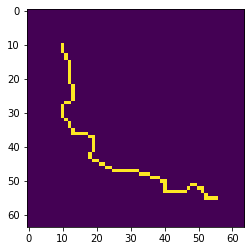

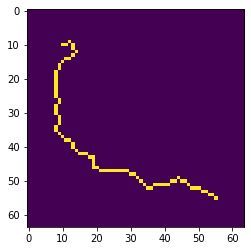

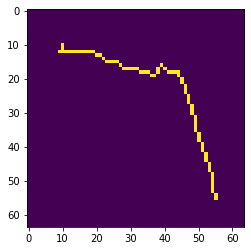

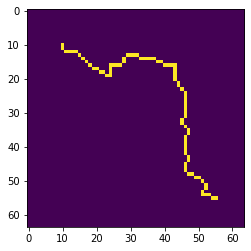

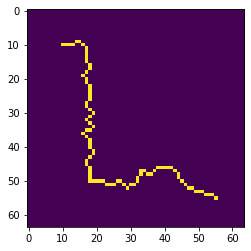

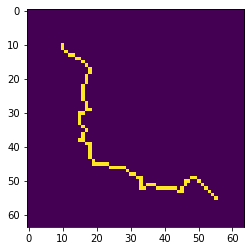

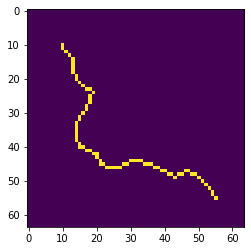

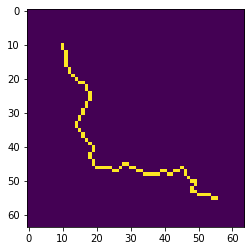

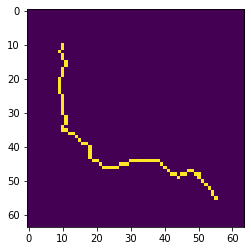

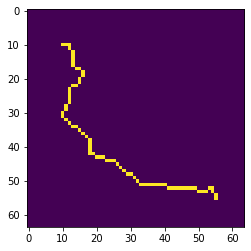

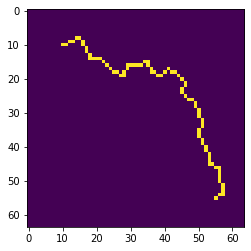

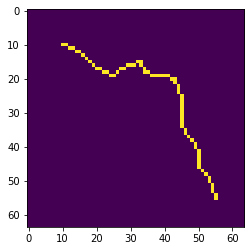

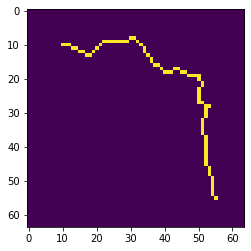

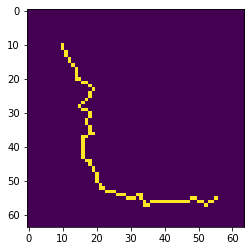

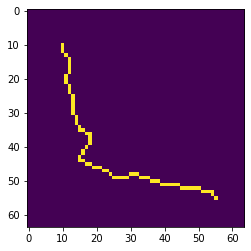

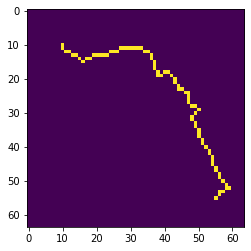

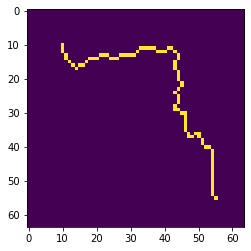

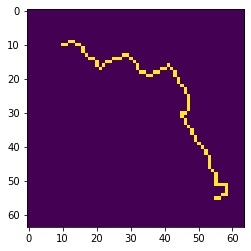

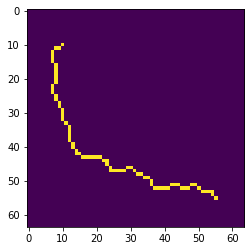

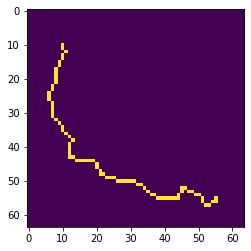

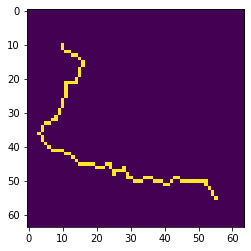

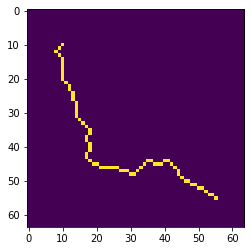

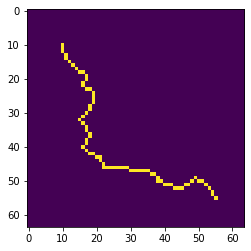

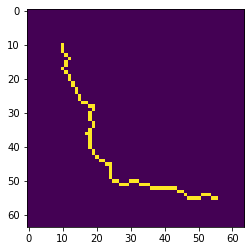

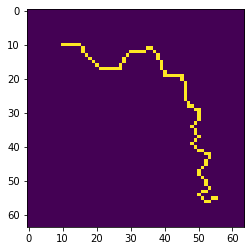

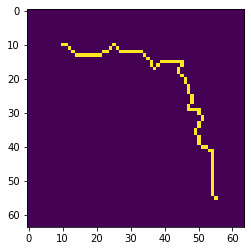

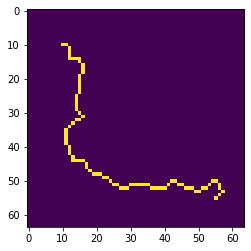

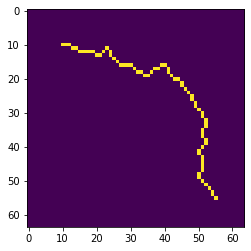

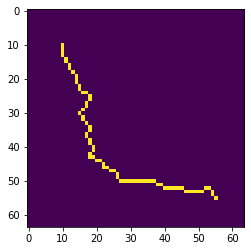

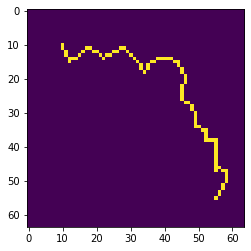

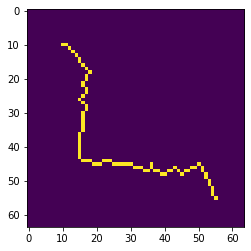

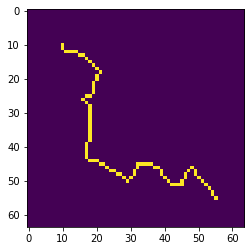

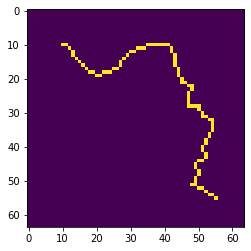

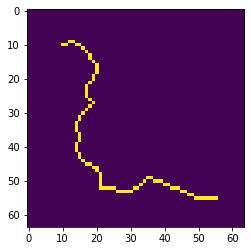

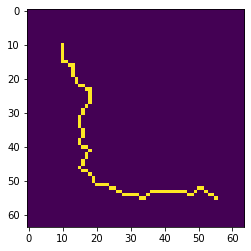

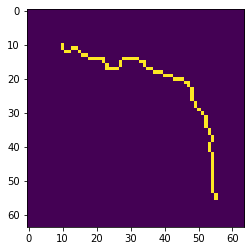

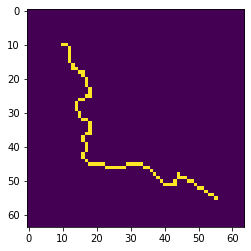

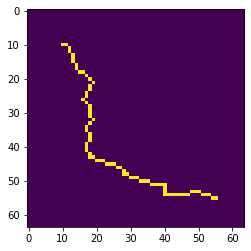

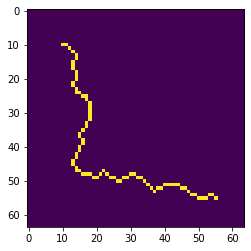

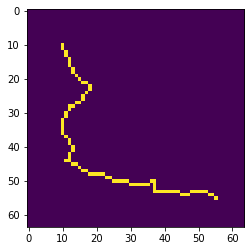

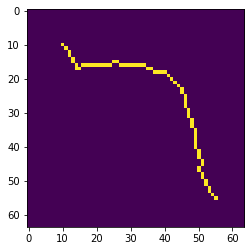

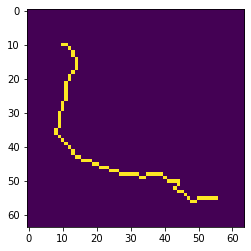

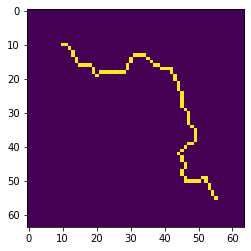

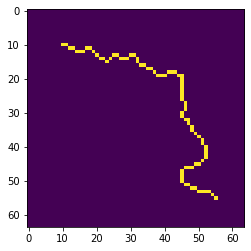

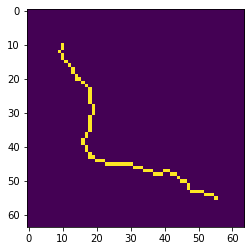

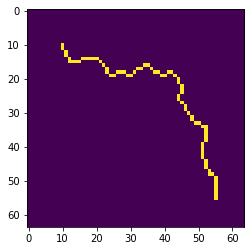

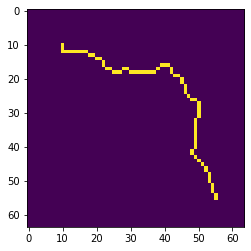

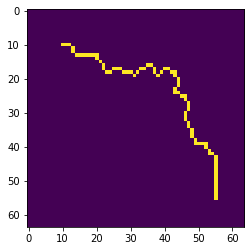

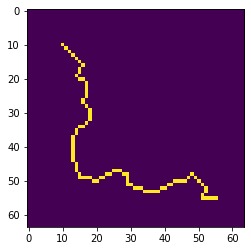

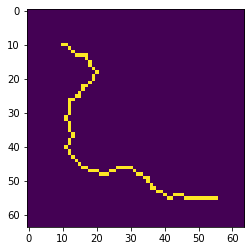

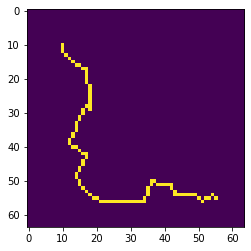

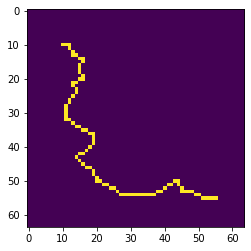

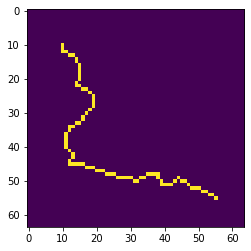

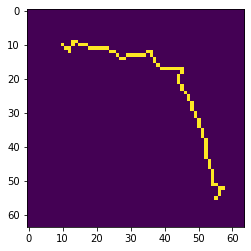

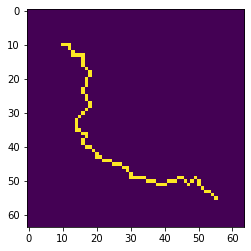

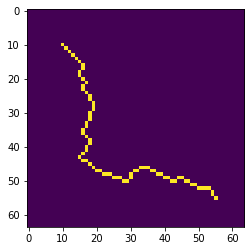

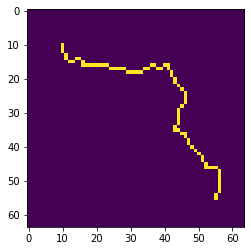

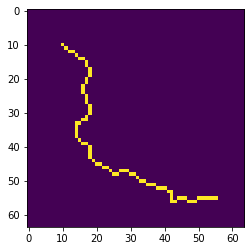

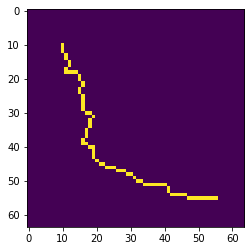

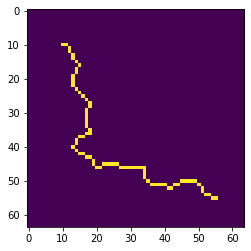

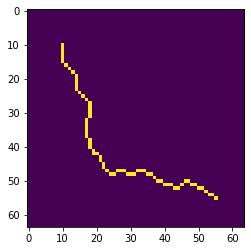

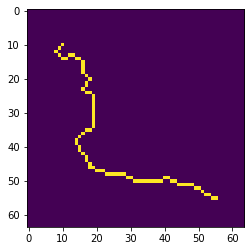

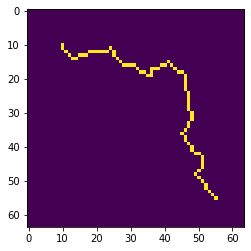

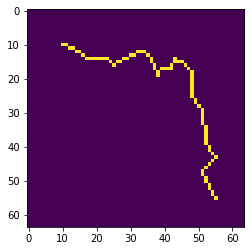

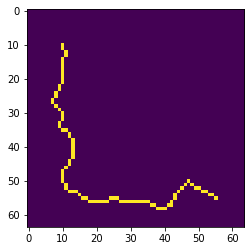

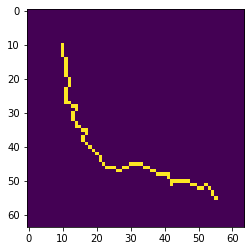

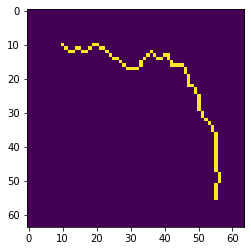

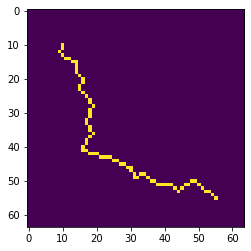

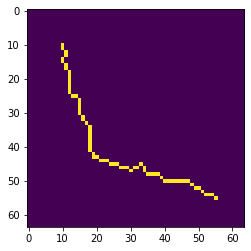

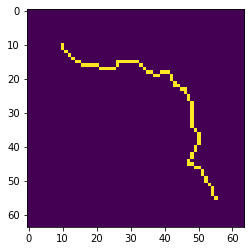

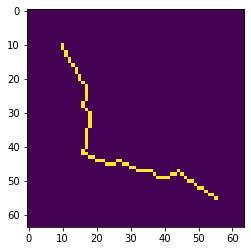

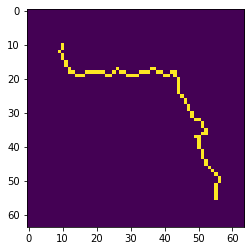

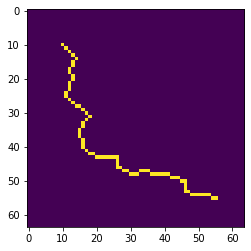

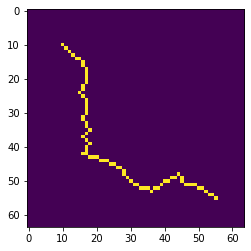

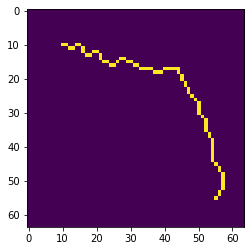

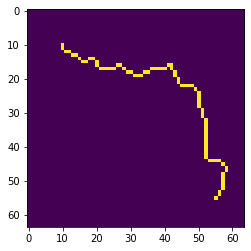

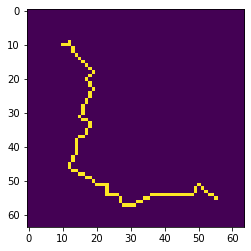

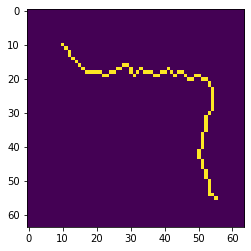

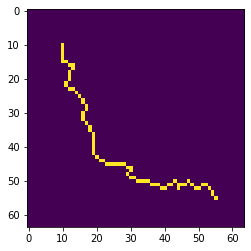

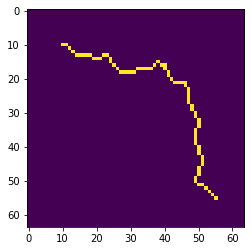

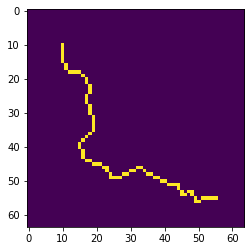

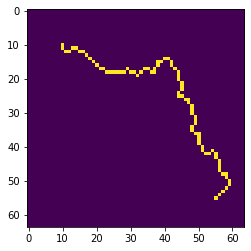

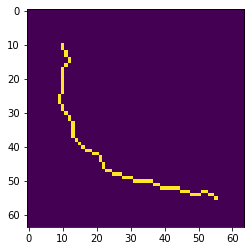

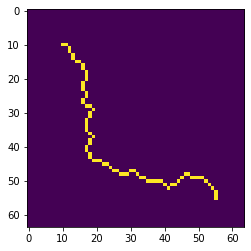

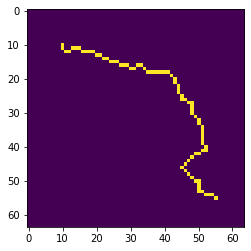

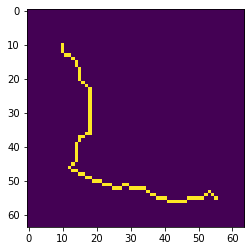

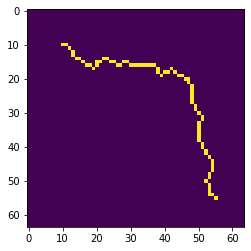

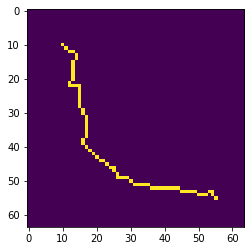

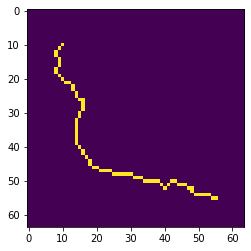

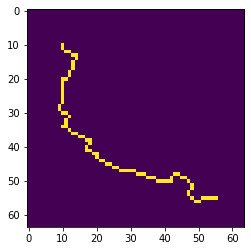

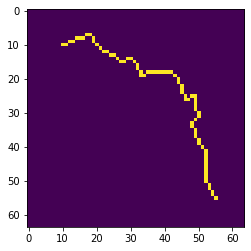

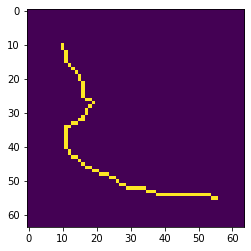

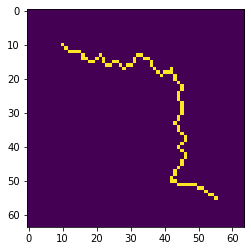

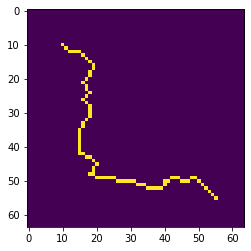

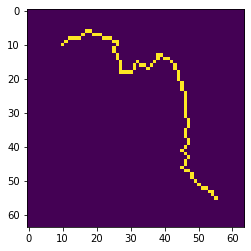

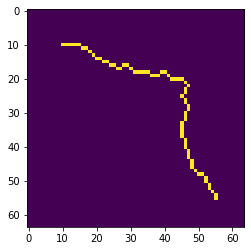

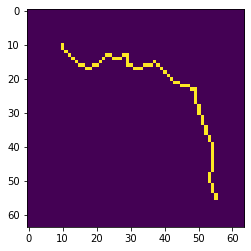

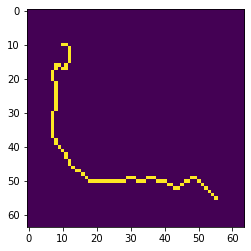

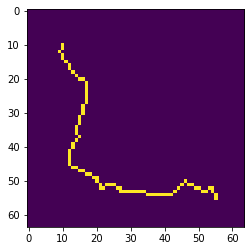

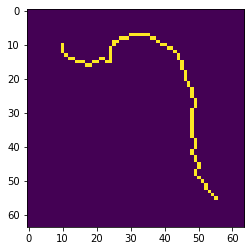

In [45]:
for file in range(100):
    image = dataset[file][0].cpu()
    plt.figure()
    plt.imshow(image)

In [13]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

In [14]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [15]:
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [16]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    # for batch_idx, (real, _) in enumerate(dataloader):
    for batch_idx, real in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device) # compute the gradient penalty
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp
            ) #   want to maximize (according to paper) but 
                                                                            #   optim algorithms are for minimizing so take - 
            critic.zero_grad()
            loss_critic.backward(retain_graph=True) # want to re use the computations for fake for generator
            opt_critic.step()

        ### Training generator: min E(critic(gen_fake))
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()        

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:BATCH_SIZE], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:BATCH_SIZE], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/20] Batch 0/400                   Loss D: 93.2982, loss G: 2.8317
Epoch [0/20] Batch 100/400                   Loss D: -184.5060, loss G: 143.1264
Epoch [0/20] Batch 200/400                   Loss D: -133.9244, loss G: 125.3307
Epoch [0/20] Batch 300/400                   Loss D: -78.2516, loss G: 72.1167
Epoch [1/20] Batch 0/400                   Loss D: -42.4492, loss G: 50.3885
Epoch [1/20] Batch 100/400                   Loss D: -26.4226, loss G: 38.5935
Epoch [1/20] Batch 200/400                   Loss D: -21.9910, loss G: 27.7059
Epoch [1/20] Batch 300/400                   Loss D: -20.8233, loss G: 24.8466
Epoch [2/20] Batch 0/400                   Loss D: -20.3536, loss G: 18.5324
Epoch [2/20] Batch 100/400                   Loss D: -19.4169, loss G: 18.1499
Epoch [2/20] Batch 200/400                   Loss D: -19.3643, loss G: 19.1323
Epoch [2/20] Batch 300/400                   Loss D: -17.2135, loss G: 18.0558
Epoch [3/20] Batch 0/400                   Loss D: -17.4

In [46]:
noise = torch.randn(100, NOISE_DIM, 1, 1).to(device)
fake = gen(noise)

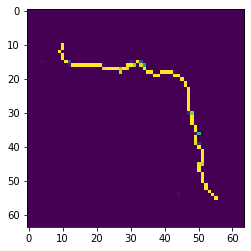

In [50]:
plt.imshow(fake.cpu().detach().numpy()[99][0])

/home/spencer/miniconda3/envs/bayesianNN/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


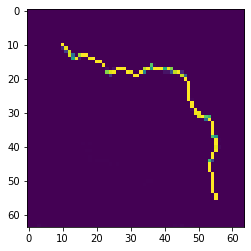

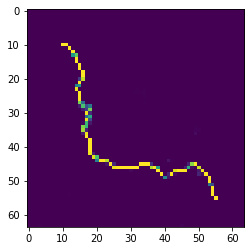

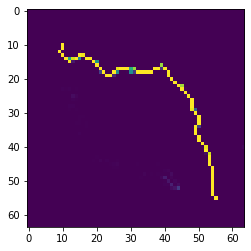

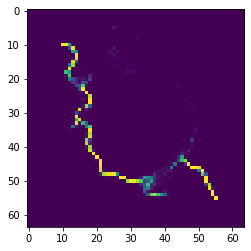

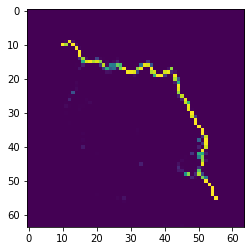

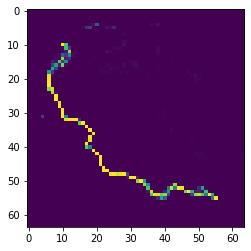

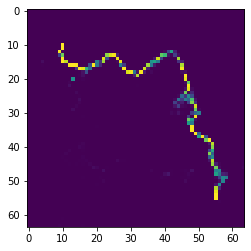

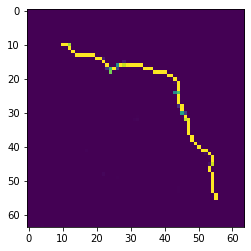

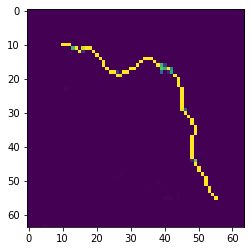

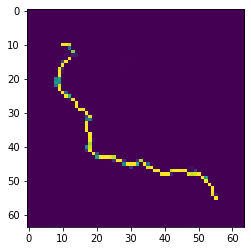

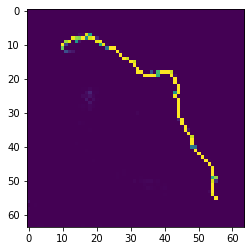

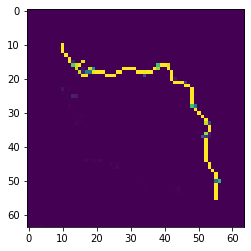

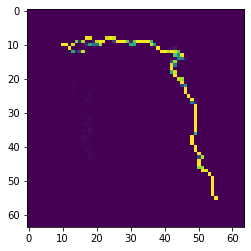

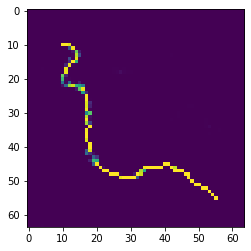

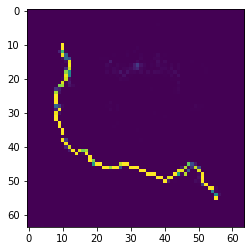

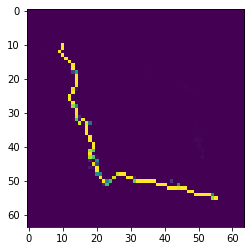

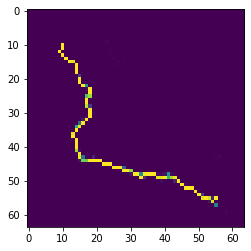

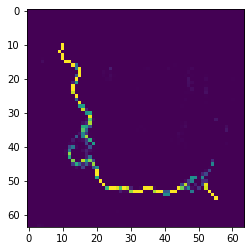

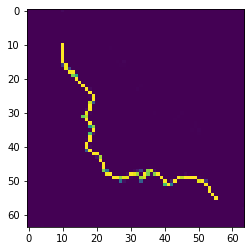

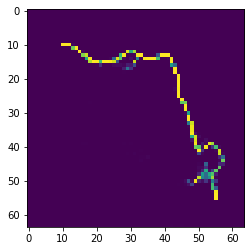

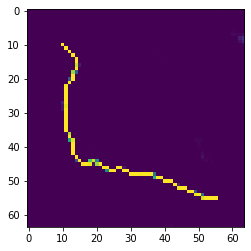

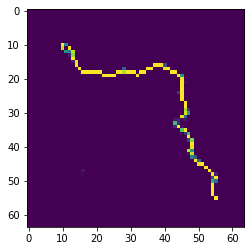

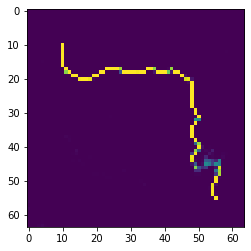

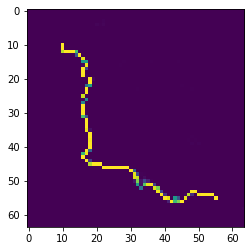

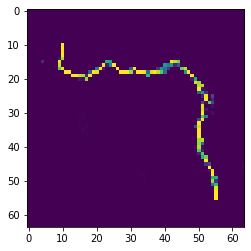

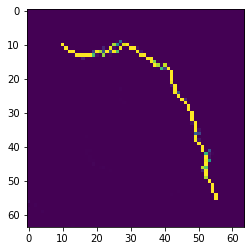

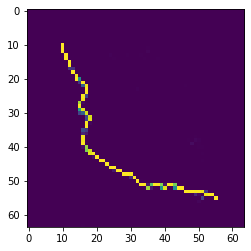

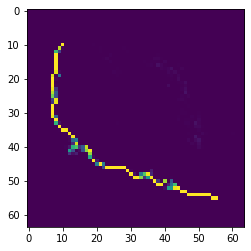

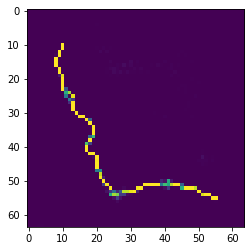

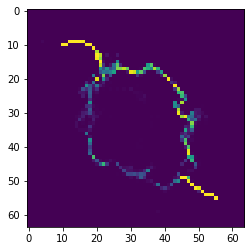

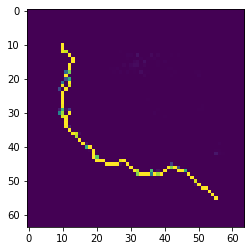

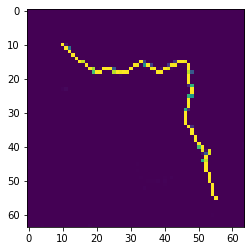

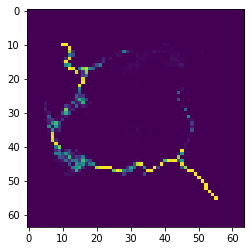

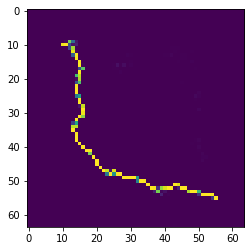

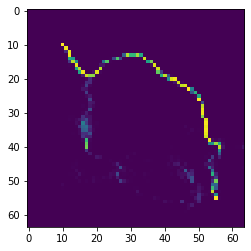

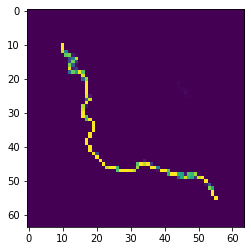

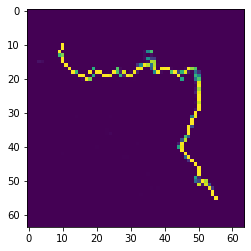

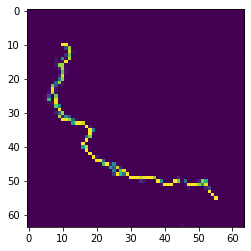

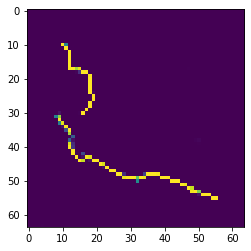

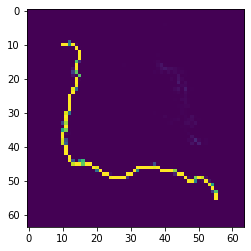

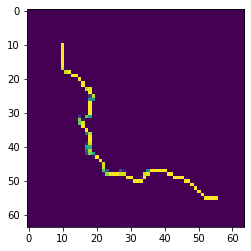

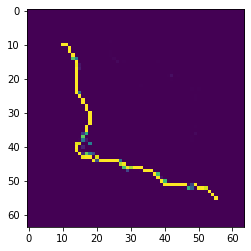

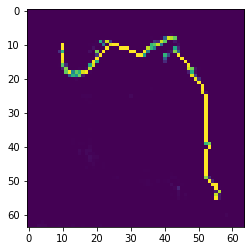

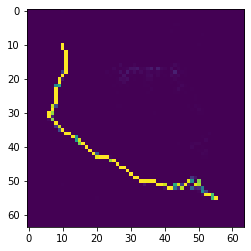

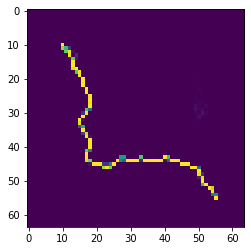

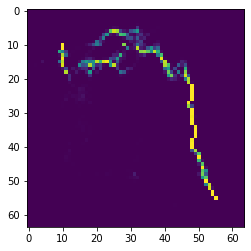

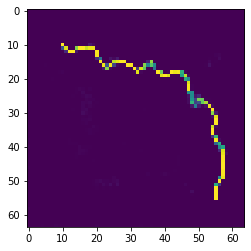

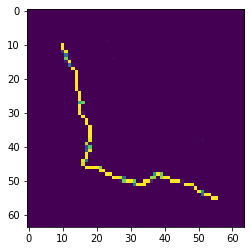

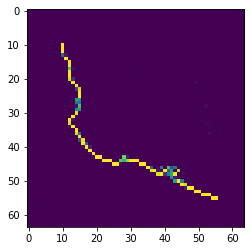

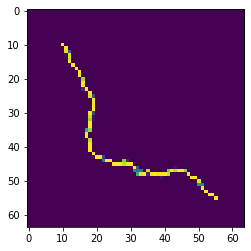

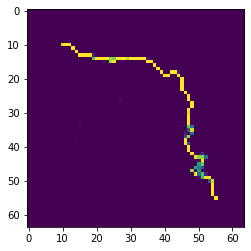

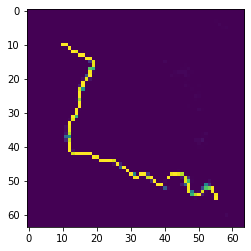

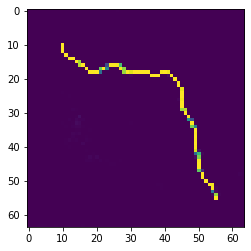

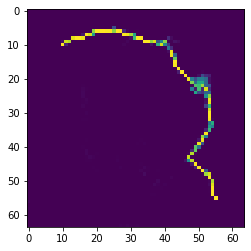

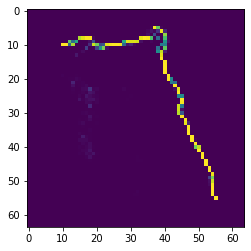

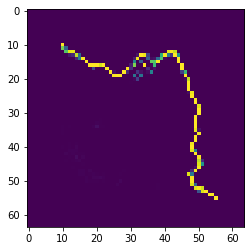

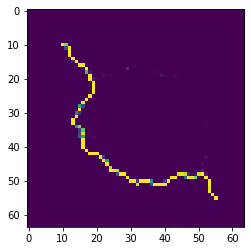

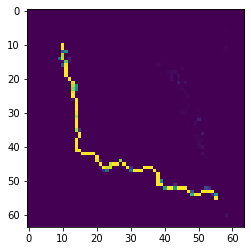

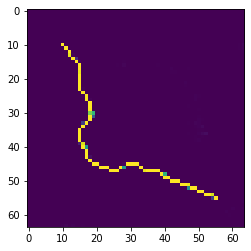

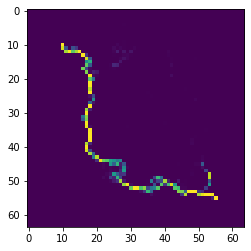

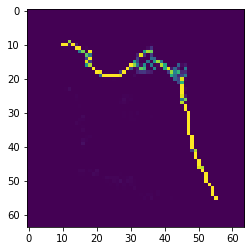

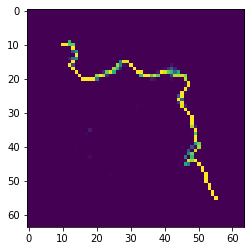

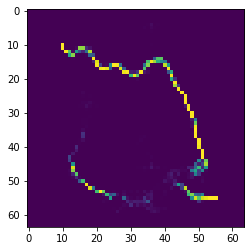

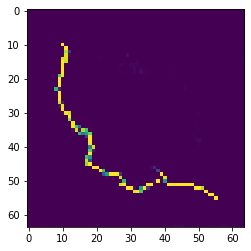

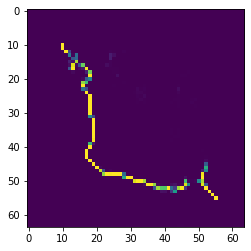

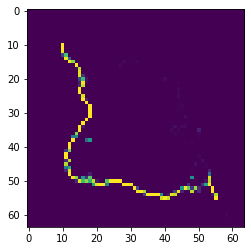

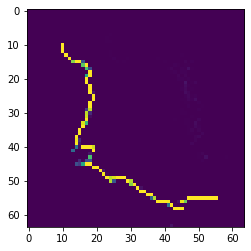

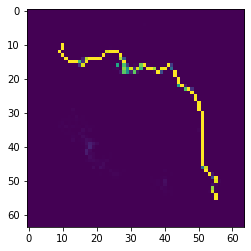

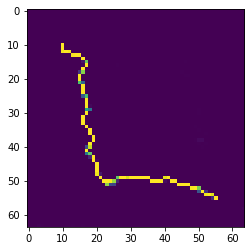

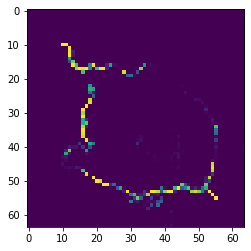

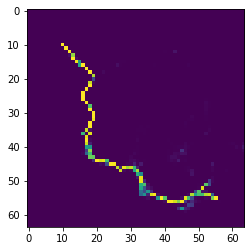

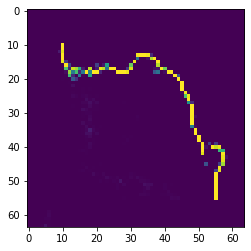

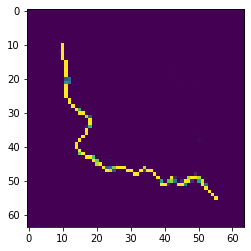

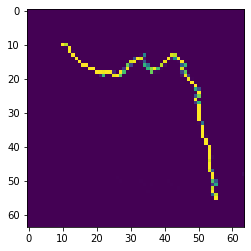

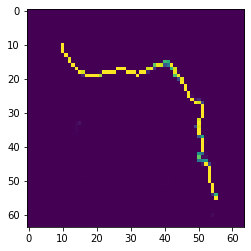

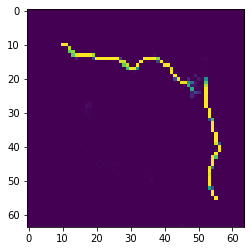

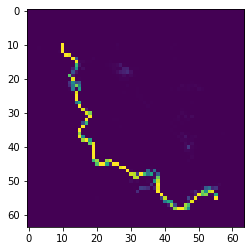

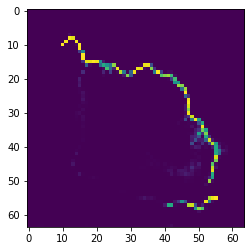

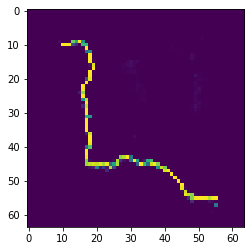

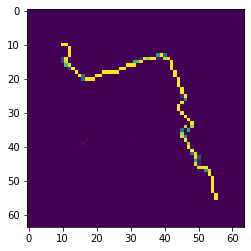

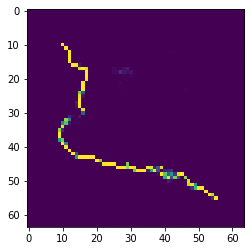

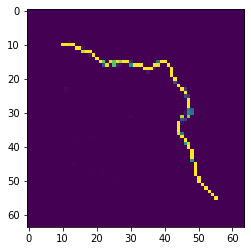

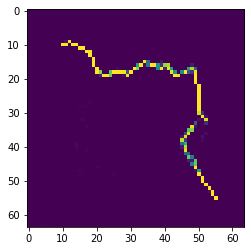

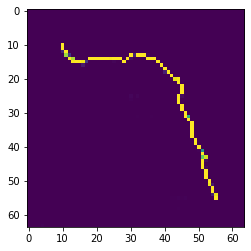

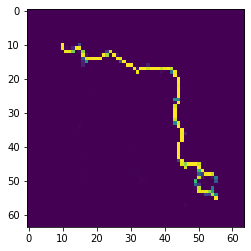

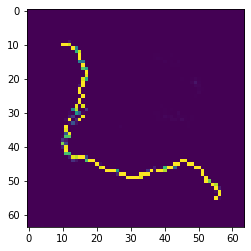

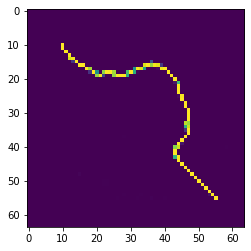

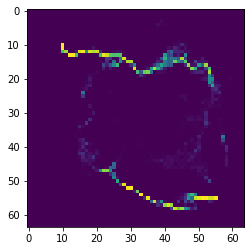

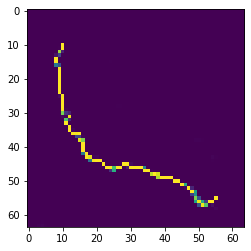

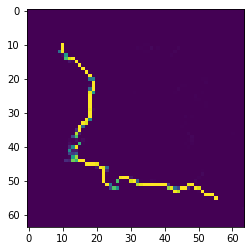

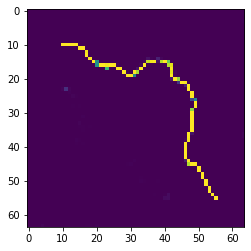

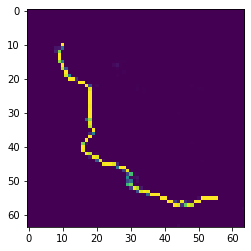

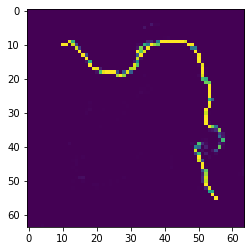

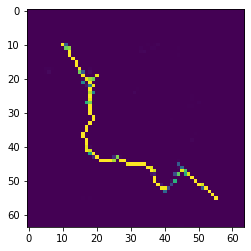

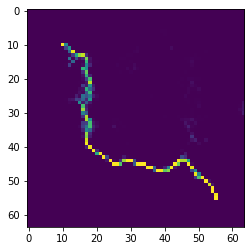

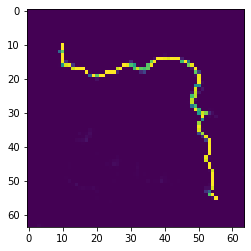

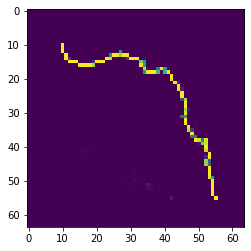

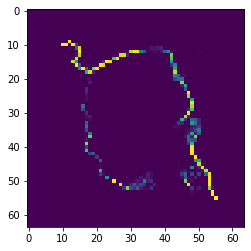

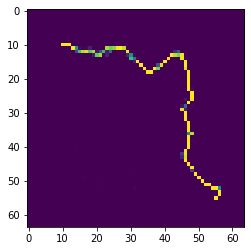

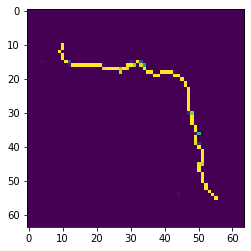

In [54]:
for file in range(100):
    image = fake.cpu().detach().numpy()[file][0]
    filename = "path_"+str(file)+"_.txt"
    np.savetxt(filename, image, delimiter=',')
    plt.figure()
    plt.imshow(image)